In [136]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm

## Подготовка датасета

In [137]:
data = pd.read_csv('https://raw.githubusercontent.com/olegov99/python-time-series/main/ts_data_Olegov.csv', sep=';', index_col=['Time'], parse_dates=['Time'], decimal=',')
data['Data'] = data['Data'].astype(float)
data.head()

,Data
Time,
2017-04-11 00:00:00,51847.91388
2017-04-11 01:00:00,51710.08145
2017-04-11 02:00:00,55167.60444
2017-04-11 03:00:00,59801.89060
2017-04-11 04:00:00,67074.13401


In [138]:
data.shape

(199, 1)

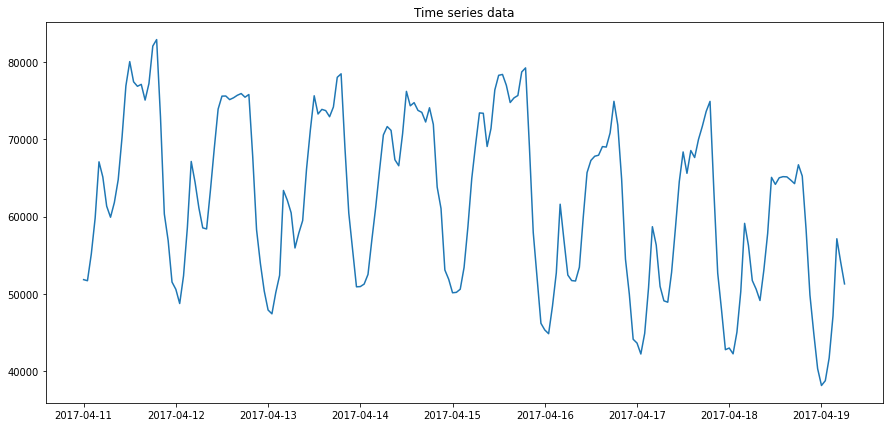

In [139]:
plt.figure(figsize=(15, 7))
plt.plot(data.Data)
plt.title('Time series data')
plt.show()

По графику видно, что временной ряд имеет нисходящий тренд. Следовательно, ряд является нестационарным. Также наблюдается сезонность.

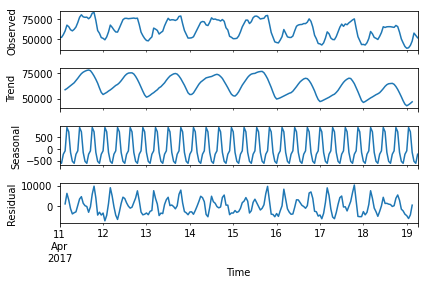

In [140]:
sm.tsa.seasonal_decompose(data['Data'], freq=7).plot();

In [141]:
print(f"Dickey-Fuller test: p={sm.tsa.stattools.adfuller(data['Data'])[1]}")

Dickey-Fuller test: p=4.290943639537913e-07


In [197]:
predictions = 30

train_data = data[:-predictions]

In [198]:
train_data

,Data
Time,
2017-04-11 00:00:00,51847.91388
2017-04-11 01:00:00,51710.08145
2017-04-11 02:00:00,55167.60444
2017-04-11 03:00:00,59801.89060
2017-04-11 04:00:00,67074.13401
...,...
2017-04-17 20:00:00,63336.06532
2017-04-17 21:00:00,52685.44340
2017-04-17 22:00:00,47900.04710


In [199]:
train_data['y_diff'] = train_data.Data - train_data.Data.shift(24)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


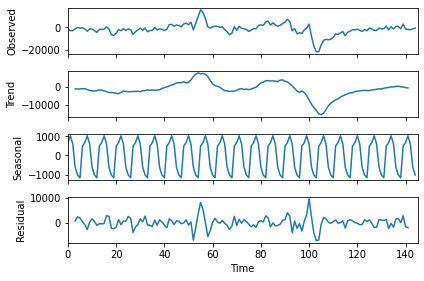

In [200]:
sm.tsa.seasonal_decompose(train_data.y_diff[24:].values, freq=7).plot();

In [201]:
print(f"Dickey-Fuller test: p={sm.tsa.stattools.adfuller(train_data.y_diff[24:])[1]}")

Dickey-Fuller test: p=0.1340924110195006


## Прогнозирование с ARIMA

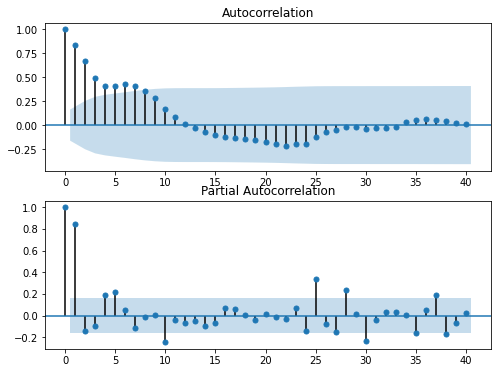

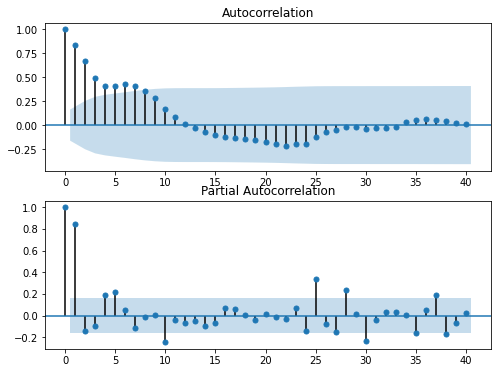

In [202]:
fig = plt.figure(figsize=(8, 6))

ax = fig.add_subplot(211)
sm.graphics.tsa.plot_acf(train_data.y_diff[24:].values.squeeze(), lags=40, ax=ax)

ax = fig.add_subplot(212)
sm.graphics.tsa.plot_pacf(train_data.y_diff[24:].values.squeeze(), lags=40, ax=ax)

На рисунке выше видно, что график автокорелляции имеет много занчительных лагов. Чтобы избавиться от них возьмем первые разности.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


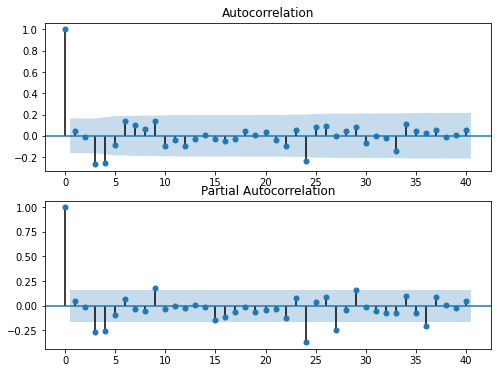

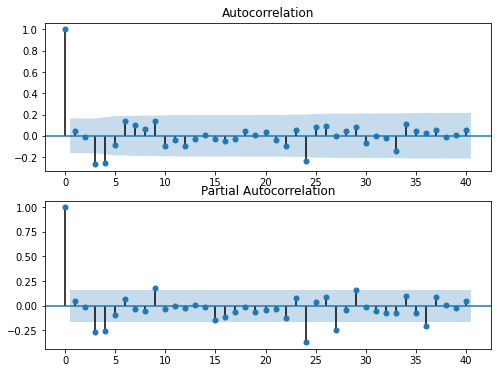

In [203]:
train_data['y_diff'] = train_data['y_diff'] - train_data['y_diff'].shift(1)

fig = plt.figure(figsize=(8, 6))

ax = fig.add_subplot(211)
sm.graphics.tsa.plot_acf(train_data.y_diff[25:].values.squeeze(), lags=40, ax=ax)

ax = fig.add_subplot(212)
sm.graphics.tsa.plot_pacf(train_data.y_diff[25:].values.squeeze(), lags=40, ax=ax)

Теперь график выглядит лучше. Из графика PACF следует, что p=4, а из ACF => q=4.

In [205]:
ps = range(2, 5)
d = 1
qs = range(2, 5)
Ps = range(0, 2)
D = 1
Qs = range(0, 2)

In [206]:
from itertools import product

parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

36

In [207]:
%%time
import warnings
from tqdm import tqdm
results1 = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in tqdm(parameters_list):
    try:
        model=sm.tsa.statespace.SARIMAX(train_data['Data'], order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 24)).fit(disp=-1)
    except (ValueError, np.linalg.LinAlgError):
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results1.append([param, model.aic])

100%|██████████| 36/36 [05:34<00:00,  9.30s/it]

CPU times: user 6min 22s, sys: 4min 33s, total: 10min 56s
Wall time: 5min 34s


In [208]:
result_table1 = pd.DataFrame(results1)
result_table1.columns = ['parameters', 'aic']
print(result_table1.sort_values(by = 'aic', ascending=True).head())

      parameters          aic
15  (3, 2, 1, 1)  2673.840582
7   (2, 3, 1, 1)  2674.489603
27  (4, 2, 1, 1)  2675.733473
3   (2, 2, 1, 1)  2675.871242
19  (3, 3, 1, 1)  2676.203026


In [214]:
import scipy.stats
train_data['y_box'], lmbda = scipy.stats.boxcox(train_data['Data']) 
print(f"The optimal Box-Cox transformation parameter: {lmbda}")

The optimal Box-Cox transformation parameter: 1.5080486616405213


In [216]:
results2 = []
best_aic = float("inf")

for param in tqdm(parameters_list):
    try:
        model=sm.tsa.statespace.SARIMAX(train_data['y_box'], order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 24)).fit(disp=-1)
    except (ValueError, np.linalg.LinAlgError):
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results2.append([param, model.aic])
    
warnings.filterwarnings('default')

100%|██████████| 36/36 [05:03<00:00,  8.43s/it]


In [217]:
result_table2 = pd.DataFrame(results2)
result_table2.columns = ['parameters', 'aic']
print(result_table2.sort_values(by = 'aic', ascending=True).head())

      parameters          aic
15  (3, 2, 1, 1)  4286.849357
7   (2, 3, 1, 1)  4287.639264
35  (4, 4, 1, 1)  4288.017696
27  (4, 2, 1, 1)  4288.577741
3   (2, 2, 1, 1)  4288.666785


Выведем информацию о лучшей модели:

In [219]:
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                              y_box   No. Observations:                  169
Model:             SARIMAX(3, 1, 2)x(1, 1, 1, 24)   Log Likelihood               -2135.425
Date:                            Tue, 23 Mar 2021   AIC                           4286.849
Time:                                    21:36:07   BIC                           4310.608
Sample:                                04-11-2017   HQIC                          4296.503
                                     - 04-18-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7021      0.400      1.754      0.079      -0.083       1.487
ar.L2         -0.4282      0.409   

Student's test: p=0.09288407132088435
Dickey-Fuller test: p=3.506163359422303e-19


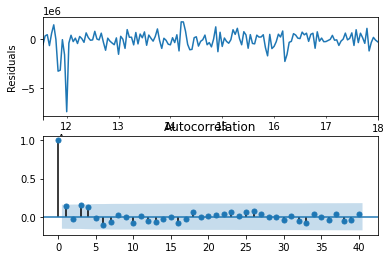

In [220]:
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=40, ax=ax)

print(f"Student's test: p={stats.ttest_1samp(best_model.resid[13:], 0)[1]}")
print(f"Dickey-Fuller test: p={sm.tsa.stattools.adfuller(best_model.resid[13:])[1]}")

In [221]:
def invboxcox(y,lmbda):
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda * y + 1) / lmbda))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


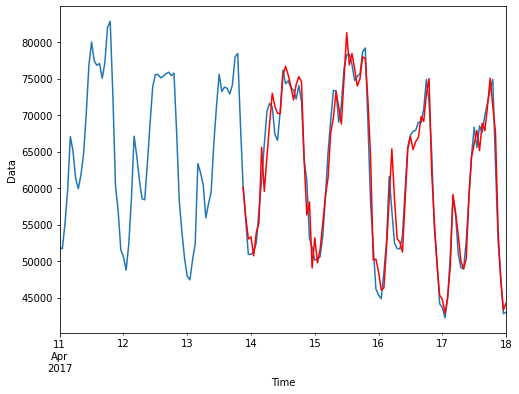

In [222]:
train_data['arima_model'] = invboxcox(best_model.fittedvalues, lmbda)

plt.figure(figsize=(8, 6))
train_data.Data.tail(200).plot()
train_data.arima_model[13:].tail(100).plot(color='r')
plt.ylabel('Data');

## Вывод
Построенная модель достаточно неплохо предсказывает последующие значения ряда.